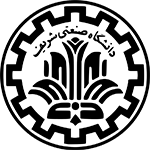

<br>
<font face="Times New Roman">
<div dir=ltr align=center>
<font color=0F5298 size=7>
 Deep Learning <br>
<font color=2565AE size=5>
Electrical Engineering Department - Fall 2025  <br>
<font color=3C99D size=5>
          Homework 4<br>
<font color=696880 size=4>

**Name**:  
  
**Student ID**:

# **Variational Auto-Encoder (VAE)**

Variational Auto-Encoders (VAEs) are a widely used class of generative models. They are simple to implement and, in contrast to other generative model classes like Generative Adversarial Networks, they optimize an explicit maximum likelihood objective to train the model. Finally, their architecture makes them well-suited for unsupervised representation learning, i.e., learning low-dimensional representations of high-dimenionsal inputs, like images, with only self-supervised objectives (data reconstruction in the case of VAEs).

**By working on this problem you will learn and practice the following steps:**
1. Set up a data loading pipeline in PyTorch.
2. Implement, train and visualize an auto-encoder architecture.
3. Extend your implementation to a variational auto-encoder.
4. Learn how to tune the critical beta parameter of your VAE.
5. Inspect the learned representation of your VAE.
6. Extend VAE's generative capabilities by conditioning it on the label you wish to generate.



# 1. MNIST Dataset[5 pt]

We will perform all experiments for this problem using the [MNIST dataset](http://yann.lecun.com/exdb/mnist/), a standard dataset of handwritten digits. The main benefits of this dataset are that it is small and relatively easy to model. It therefore allows for quick experimentation and serves as initial test bed in many papers.


In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0,2"

In [5]:
import torch
import torchvision
from torchvision import transforms

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')   # use GPU if available
print(f"Using device: {device}")

# this will automatically download the MNIST training set
mnist_train = torchvision.datasets.MNIST(
    root="./data",
    train=True,
    download=True,
    transform=transforms.ToTensor()
)

print("\n Download complete! Downloaded {} training examples!".format(len(mnist_train)))

Using device: cuda:0


100%|██████████| 9.91M/9.91M [00:00<00:00, 16.7MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 505kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.69MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 10.4MB/s]


 Download complete! Downloaded 60000 training examples!


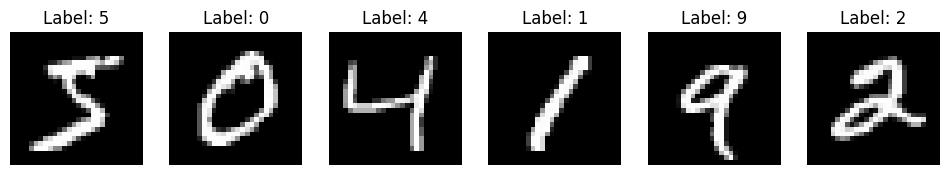

In [6]:
import matplotlib.pyplot as plt

# show first 6 images
fig, axes = plt.subplots(1, 6, figsize=(12, 2))

for i, ax in enumerate(axes):
    img, label = mnist_train[i]
    ax.imshow(img.squeeze(), cmap='gray')
    ax.set_title(f"Label: {label}")
    ax.axis('off')

plt.show()

# 2. Auto-Encoder[35 pt]

Before implementing the full VAE, we will first implement an **auto-encoder architecture**. Auto-encoders use an encoder–decoder architecture to learn low-dimensional representations of data without supervision. The encoder compresses the input image into a small latent vector using fully connected layers, and the decoder maps this vector back to the original image space. The model is trained by minimizing a reconstruction loss between the input and the reconstructed output. Because image pixels contain redundant information, the auto-encoder can learn a compact embedding that still preserves key features such as digit identity and shape. This compressed representation can make downstream tasks easier. In this assignment, you will define encoder and decoder networks and then train the auto-encoder.

Learning such a **compressed representation can make downstream task learning easier**. For example, learning to add two numbers based on the inferred digits is much easier than performing the task based on two piles of pixel values that depict the digits.

In the following, we will first define the architecture of encoder and decoder and then train the auto-encoder model.

## Defining the Auto-Encoder Architecture[10 pt]

In [7]:
import torch
import torch.nn as nn

class Encoder(nn.Module):
  def __init__(self, nz, input_size):
    super().__init__()
    self.input_size = input_size
    self.net = nn.Sequential(
        nn.Flatten(),                       # (B, 1, 28, 28) -> (B, 784)
        nn.Linear(input_size, 512),
        nn.ReLU(inplace=True),
        nn.Linear(512, 256),
        nn.ReLU(inplace=True),
        nn.Linear(256, nz)                  # (B, nz)
    )

  def forward(self, x):
    return self.net(x)


class Decoder(nn.Module):
  def __init__(self, nz, output_size):
    super().__init__()
    self.output_size = output_size
    self.net = nn.Sequential(
        nn.Linear(nz, 256),
        nn.ReLU(inplace=True),
        nn.Linear(256, 512),
        nn.ReLU(inplace=True),
        nn.Linear(512, output_size),
        nn.Sigmoid()                        # outputs in [0,1] to match ToTensor()
    )

  def forward(self, z):
    return self.net(z).reshape(-1, 1, 28, 28)

## Testing the Auto-Encoder Forward Pass[5 pt]

To verify that your auto-encoder is implemented correctly, you will create a DataLoader for sampling training batches and then run a forward pass through the encoder and decoder. This test ensures that your networks accept inputs of the expected shape and produce latent vectors and reconstructions with the correct dimensions.

In [8]:
from torch.utils.data import DataLoader

batch_size = 64
nworkers = 2

mnist_data_loader = DataLoader(
    mnist_train,
    batch_size=batch_size,
    shuffle=True,
    num_workers=nworkers,
    pin_memory=True
)

in_size = out_size = 28*28
nz = 32
encoder = Encoder(nz=nz, input_size=in_size)
decoder = Decoder(nz=nz, output_size=out_size)

for sample_img, sample_label in mnist_data_loader:
    print(f'{sample_img.shape=}, {type(sample_img)}')   # should be (B,1,28,28)
    enc = encoder(sample_img)
    print(f"Shape of encoding vector (should be [B, nz]): {enc.shape}")
    dec = decoder(enc)
    print("Shape of decoded image (should be [B, 1, 28, 28]): {}.".format(dec.shape))
    break

sample_img.shape=torch.Size([64, 1, 28, 28]), <class 'torch.Tensor'>
Shape of encoding vector (should be [B, nz]): torch.Size([64, 32])
Shape of decoded image (should be [B, 1, 28, 28]): torch.Size([64, 1, 28, 28]).


Now that we defined encoder and decoder network our architecture is nearly complete. However, before we start training, we can wrap encoder and decoder into an auto-encoder class for easier handling.

In [9]:
import torch
import torch.nn as nn

class AutoEncoder(nn.Module):
  def __init__(self, nz):
    super().__init__()
    self.in_size = 28 * 28
    self.out_size = 28 * 28
    self.nz = nz
    self.encoder = Encoder(nz=nz, input_size=self.in_size)
    self.decoder = Decoder(nz=nz, output_size=self.out_size)

  def forward(self, x):
    z = self.encoder(x)         # (B, nz)
    x_hat = self.decoder(z)     # (B, 1, 28, 28)
    return x_hat

  def reconstruct(self, x):
    """Only used later for visualization."""
    with torch.no_grad():
      image = self.forward(x)
    return image

## Setting up the Auto-Encoder Training Loop[5 pt]
After implementing the network architecture, we can now set up the training loop and run training.

In [10]:
import torch
import torch.nn as nn

epochs = 10
learning_rate = 1e-3

print(f'Device available {device}')
ae_model = AutoEncoder(nz).to(device)
ae_model = ae_model.train()

# build optimizer and loss function
optimizer = torch.optim.Adam(ae_model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()   # (also works well with Sigmoid outputs)

train_it = 0
for ep in range(epochs):
    print("Run Epoch {}".format(ep))

    running_loss = 0.0
    for data, _ in mnist_data_loader:
        data = data.to(device)                 # (B,1,28,28)

        optimizer.zero_grad()
        recon = ae_model(data)                 # (B,1,28,28)

        rec_loss = criterion(recon, data)
        rec_loss.backward()
        optimizer.step()

        running_loss += rec_loss.item()
        train_it += 1

    avg_loss = running_loss / len(mnist_data_loader)
    print(f"Epoch {ep} | recon loss: {avg_loss:.6f}")

print("Done!")
del epochs, learning_rate, data, train_it, rec_loss

Device available cuda:0
Run Epoch 0
Epoch 0 | recon loss: 0.031987
Run Epoch 1
Epoch 1 | recon loss: 0.013583
Run Epoch 2
Epoch 2 | recon loss: 0.010140
Run Epoch 3
Epoch 3 | recon loss: 0.008483
Run Epoch 4
Epoch 4 | recon loss: 0.007539
Run Epoch 5
Epoch 5 | recon loss: 0.006923
Run Epoch 6
Epoch 6 | recon loss: 0.006476
Run Epoch 7
Epoch 7 | recon loss: 0.006124
Run Epoch 8
Epoch 8 | recon loss: 0.005842
Run Epoch 9
Epoch 9 | recon loss: 0.005602
Done!


## Verifying reconstructions[5 pt]
Now that we trained the auto-encoder we can visualize some of the reconstructions on the test set to verify that it is converged and did not overfit. **Before continuing, make sure that your auto-encoder is able to reconstruct these samples near-perfectly.**

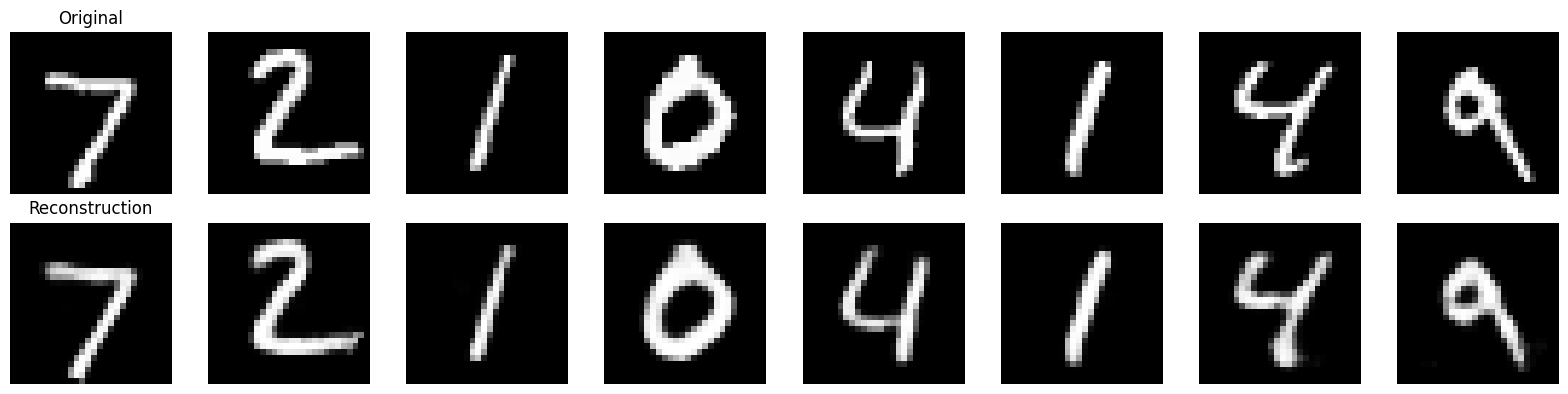

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision

def vis_reconstruction(model, randomize=False):
    mnist_test = torchvision.datasets.MNIST(
        root='./data',
        train=False,
        download=True,
        transform=torchvision.transforms.ToTensor()
    )

    model.eval()
    n = 8  # number of examples to show

    # pick indices
    if randomize:
        idxs = np.random.choice(len(mnist_test), size=n, replace=False)
    else:
        idxs = np.arange(n)

    # stack into a batch
    imgs = torch.stack([mnist_test[i][0] for i in idxs], dim=0)  # (n,1,28,28)
    imgs = imgs.to(next(model.parameters()).device)

    with torch.no_grad():
        recons = model.reconstruct(imgs)  # (n,1,28,28)

    # plot: 2 rows (orig, recon)
    fig, axes = plt.subplots(2, n, figsize=(2*n, 4))
    for i in range(n):
        axes[0, i].imshow(imgs[i].detach().cpu().squeeze(), cmap='gray')
        axes[0, i].axis('off')
        if i == 0:
            axes[0, i].set_title("Original")

        axes[1, i].imshow(recons[i].detach().cpu().squeeze(), cmap='gray')
        axes[1, i].axis('off')
        if i == 0:
            axes[1, i].set_title("Reconstruction")

    plt.tight_layout()
    plt.show()
    model.train()  # restore train mode if you keep training later

vis_reconstruction(ae_model, randomize=False)

## Sampling from the Auto-Encoder[5 pt]

To test whether the auto-encoder is useful as a generative model, we can use it like any other generative model: draw embedding samples from a prior distribution and decode them through the decoder network. We will choose a unit Gaussian prior to allow for easy comparison to the VAE later.

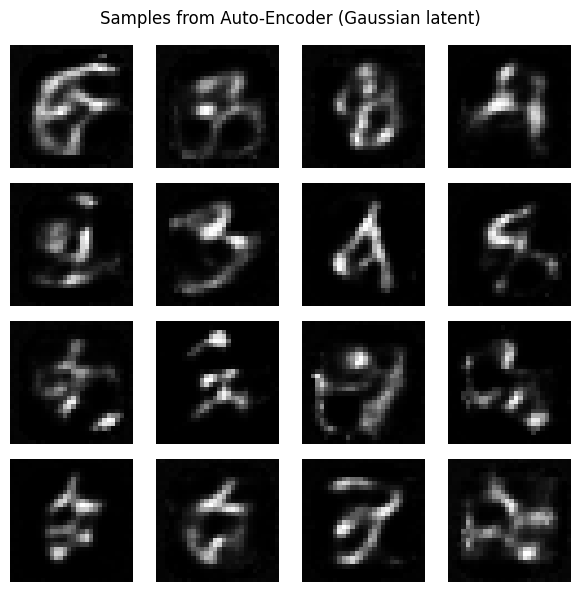

In [21]:
# Sampling from the Auto-Encoder

%matplotlib inline
import torch
import matplotlib.pyplot as plt

def vis_samples(model):
    model.eval()
    device = next(model.parameters()).device

    N = 16  # number of samples to visualize
    nz = model.nz

    # sample latent vectors from N(0, I)
    z = torch.randn(N, nz, device=device)

    with torch.no_grad():
        samples = model.decoder(z)

    samples = samples.detach().cpu()

    # handle both possible decoder output shapes
    if samples.dim() == 3 and samples.shape[-1] == 28 * 28:
        samples = samples.view(N, 1, 28, 28)

    fig, axes = plt.subplots(4, 4, figsize=(6, 6))
    axes = axes.flatten()

    for i in range(N):
        axes[i].imshow(samples[i].squeeze(), cmap='gray')
        axes[i].axis('off')

    plt.suptitle("Samples from Auto-Encoder (Gaussian latent)")
    plt.tight_layout()
    plt.show()

    model.train()

vis_samples(ae_model)

>**Inline Question: Describe your observations, why do you think they occur? [5 pt]**



The generated samples from the auto-encoder are blurry and only partially resemble handwritten digits. While some digit-like strokes are visible, most images lack clear structure and are often ambiguous or distorted.

This occurs because a standard auto-encoder does not enforce any specific structure or distribution on its latent space. During training, the encoder learns latent representations only for the training data manifold. When we sample latent vectors from a unit Gaussian distribution, many of these samples lie in regions of latent space that were never seen during training. As a result, the decoder produces unrealistic or noisy outputs.

This highlights a key limitation of vanilla auto-encoders as generative models and motivates the use of Variational Auto-Encoders (VAEs), which explicitly regularize the latent space to follow a known distribution, enabling meaningful sampling.


# 3. Variational Auto-Encoder (VAE)[35 pt]

Variational auto-encoders use a very similar architecture to deterministic auto-encoders, but are inherently storchastic models, i.e. we perform a stochastic sampling operation during the forward pass, leading to different different outputs every time we run the network for the same input. This sampling is required to optimize the VAE objective also known as the evidence lower bound (ELBO):

$$
p(x) > \underbrace{\mathbb{E}_{z\sim q(z\vert x)} p(x \vert z)}_{\text{reconstruction}} - \underbrace{D_{\text{KL}}\big(q(z \vert x), p(z)\big)}_{\text{prior divergence}}
$$


For simplicity, we will choose a unit Gaussian prior again. The first term is the reconstruction term we already know from training the auto-encoder. When assuming a Gaussian output distribution for both encoder $q(z \vert x)$ and decoder $p(x \vert z)$ the objective reduces to:

$$
\mathcal{L}_{\text{VAE}} = \sum_{x\sim \mathcal{D}} \mathcal{L}_{\text{rec}}(x, \hat{x}) - \beta \cdot D_{\text{KL}}\big(\mathcal{N}(\mu_q, \sigma_q), \mathcal{N}(0, I)\big)
$$


The coefficient $\beta$ is a scalar weighting factor that trades off between reconstruction and regularization objective. We will investigate the influence of this factor in out experiments below.


### Reparametrization Trick

The sampling procedure inside the VAE's forward pass for obtaining a sample $z$ from the posterior distribution $q(z \vert x)$, when implemented naively, is non-differentiable. However, since $q(z\vert x)$ is parametrized with a Gaussian function, there is a simple trick to obtain a differentiable sampling operator, known as the _reparametrization trick_.

Instead of directly sampling $z \sim \mathcal{N}(\mu_q, \sigma_q)$ we can "separate" the network's predictions and the random sampling by computing the sample as:

$$
z = \mu_q + \sigma_q * \epsilon , \quad \epsilon \sim \mathcal{N}(0, I)
$$

Note that in this equation, the sample $z$ is computed as a deterministic function of the network's predictions $\mu_q$ and $\sigma_q$ and therefore allows to propagate gradients through the sampling procedure.

**Note**: While in the equations above the encoder network parametrizes the standard deviation $\sigma_q$ of the Gaussian posterior distribution, in practice we usually parametrize the **logarithm of the standard deviation** $\log \sigma_q$ for numerical stability. Before sampling $z$ we will then exponentiate the network's output to obtain $\sigma_q$.



## Defining the VAE Model [15 pt]

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F

def kl_divergence(mu1, log_sigma1, mu2, log_sigma2):
  """
  KL( N(mu1, sigma1^2) || N(mu2, sigma2^2) ) for diagonal Gaussians.
  log_sigma are log standard deviations.
  Returns per-sample KL (shape: [B]).
  """
  sigma1 = torch.exp(log_sigma1)
  sigma2 = torch.exp(log_sigma2)

  var1 = sigma1 ** 2
  var2 = sigma2 ** 2

  kl = (log_sigma2 - log_sigma1) + (var1 + (mu1 - mu2) ** 2) / (2.0 * var2) - 0.5
  return kl.sum(dim=1)  # sum over latent dims -> (B,)

class VAE(nn.Module):
  def __init__(self, nz, beta=1.0):
    super().__init__()
    self.beta = beta
    self.nz = nz

    in_size = out_size = 28 * 28

    # shared encoder trunk
    self.enc = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_size, 512),
        nn.ReLU(inplace=True),
        nn.Linear(512, 256),
        nn.ReLU(inplace=True),
    )
    # posterior parameters
    self.enc_mu = nn.Linear(256, nz)
    self.enc_logsigma = nn.Linear(256, nz)

    # decoder
    self.dec = nn.Sequential(
        nn.Linear(nz, 256),
        nn.ReLU(inplace=True),
        nn.Linear(256, 512),
        nn.ReLU(inplace=True),
        nn.Linear(512, out_size),
        nn.Sigmoid()
    )

  def forward(self, x):
    h = self.enc(x)
    mu = self.enc_mu(h)
    log_sigma = self.enc_logsigma(h)

    # reparameterization trick
    eps = torch.randn_like(mu)
    z = mu + torch.exp(log_sigma) * eps

    reconstruction = self.dec(z).view(-1, 1, 28, 28)

    q = {'mu': mu, 'log_sigma': log_sigma, 'z': z}
    return {'q': q,
            'rec': reconstruction}

  def loss(self, x, outputs):
    rec = outputs['rec']
    q = outputs['q']

    # reconstruction loss (mean over batch)
    rec_loss = F.mse_loss(rec, x, reduction='mean')

    # KL to unit Gaussian prior p(z)=N(0,I)
    mu2 = torch.zeros_like(q['mu'])
    log_sigma2 = torch.zeros_like(q['log_sigma'])
    kl_per_sample = kl_divergence(q['mu'], q['log_sigma'], mu2, log_sigma2)
    kl_loss = kl_per_sample.mean()

    return rec_loss + self.beta * kl_loss, {'rec_loss': rec_loss, 'kl_loss': kl_loss}

  def reconstruct(self, x):
    """Use mean of posterior estimate for visualization reconstruction."""
    self.eval()
    with torch.no_grad():
      h = self.enc(x)
      mu = self.enc_mu(h)  # mean
      image = self.dec(mu).view(-1, 1, 28, 28)
    self.train()
    return image

## Setting up the VAE Training Loop [5 pt]

Let's start training the VAE model! We will first verify our implementation by setting $\beta = 0$.


Running 10 epochs with beta=0.0
Run Epoch 0
Epoch 0 | rec: 0.032461 | kl: 261.641055
Run Epoch 1
Epoch 1 | rec: 0.012653 | kl: 467.084858
Run Epoch 2
Epoch 2 | rec: 0.009530 | kl: 500.640632
Run Epoch 3
Epoch 3 | rec: 0.008036 | kl: 501.368144
Run Epoch 4
Epoch 4 | rec: 0.007202 | kl: 498.588594
Run Epoch 5
Epoch 5 | rec: 0.006624 | kl: 502.369230
Run Epoch 6
Epoch 6 | rec: 0.006197 | kl: 503.969892
Run Epoch 7
Epoch 7 | rec: 0.005875 | kl: 506.941668
Run Epoch 8
Epoch 8 | rec: 0.005628 | kl: 513.216704
Run Epoch 9
Epoch 9 | rec: 0.005408 | kl: 509.956791
Done!


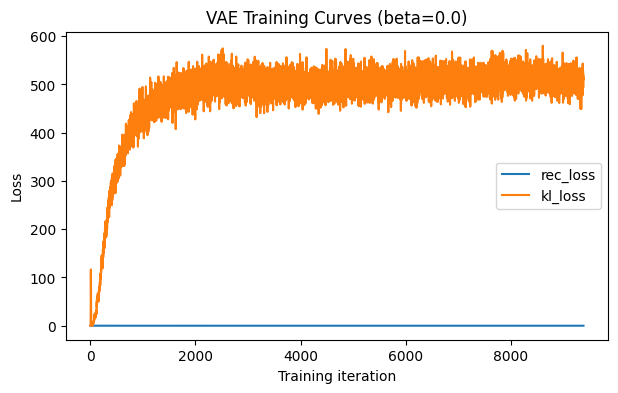

In [18]:
# Setting up the VAE Training Loop (verify with beta = 0)

import torch
import matplotlib.pyplot as plt

learning_rate = 1e-3
nz = 32
beta = 0.0
epochs = 10
optimizer = None  # will be set after model creation

vae_model = VAE(nz, beta).to(device)
vae_model = vae_model.train()

optimizer = torch.optim.Adam(vae_model.parameters(), lr=learning_rate)

train_it = 0
rec_loss, kl_loss = [], []
print(f"Running {epochs} epochs with {beta=}")

for ep in range(epochs):
    print("Run Epoch {}".format(ep))

    running_rec = 0.0
    running_kl = 0.0

    for data, _ in mnist_data_loader:
        data = data.to(device)

        optimizer.zero_grad()
        outputs = vae_model(data)
        loss, losses = vae_model.loss(data, outputs)

        loss.backward()
        optimizer.step()

        rec_loss.append(losses['rec_loss'].detach())
        kl_loss.append(losses['kl_loss'].detach())

        running_rec += losses['rec_loss'].item()
        running_kl += losses['kl_loss'].item()
        train_it += 1

    avg_rec = running_rec / len(mnist_data_loader)
    avg_kl = running_kl / len(mnist_data_loader)
    print(f"Epoch {ep} | rec: {avg_rec:.6f} | kl: {avg_kl:.6f}")

print("Done!")

rec_loss_plotdata = [foo.detach().cpu() for foo in rec_loss]
kl_loss_plotdata = [foo.detach().cpu() for foo in kl_loss]

# log the loss training curves
plt.figure(figsize=(7,4))
plt.plot(rec_loss_plotdata, label="rec_loss")
plt.plot(kl_loss_plotdata, label="kl_loss")
plt.xlabel("Training iteration")
plt.ylabel("Loss")
plt.legend()
plt.title(f"VAE Training Curves (beta={beta})")
plt.show()

In [22]:
import torch
import matplotlib.pyplot as plt

def vis_samples(model, N=16):
    model.eval()
    device = next(model.parameters()).device

    # infer latent size
    nz = getattr(model, "nz", None)
    if nz is None:
        raise ValueError("Model must have attribute 'nz' (latent dimension).")

    z = torch.randn(N, nz, device=device)

    with torch.no_grad():
        # AutoEncoder has .decoder, VAE has .dec
        if hasattr(model, "decoder"):
            samples = model.decoder(z)
        elif hasattr(model, "dec"):
            samples = model.dec(z)
        else:
            raise AttributeError("Model has neither 'decoder' nor 'dec'.")

    samples = samples.detach().cpu()

    # handle both (N,1,784) and (N,1,28,28)
    if samples.dim() == 3 and samples.shape[-1] == 28 * 28:
        samples = samples.view(N, 1, 28, 28)
    elif samples.dim() == 2 and samples.shape[-1] == 28 * 28:
        samples = samples.view(N, 1, 28, 28)

    fig, axes = plt.subplots(4, 4, figsize=(6, 6))
    axes = axes.flatten()
    for i in range(N):
        axes[i].imshow(samples[i].squeeze(), cmap="gray")
        axes[i].axis("off")

    plt.suptitle("Samples from latent prior z ~ N(0, I)")
    plt.tight_layout()
    plt.show()

    model.train()

Let's look at some reconstructions and decoded embedding samples!

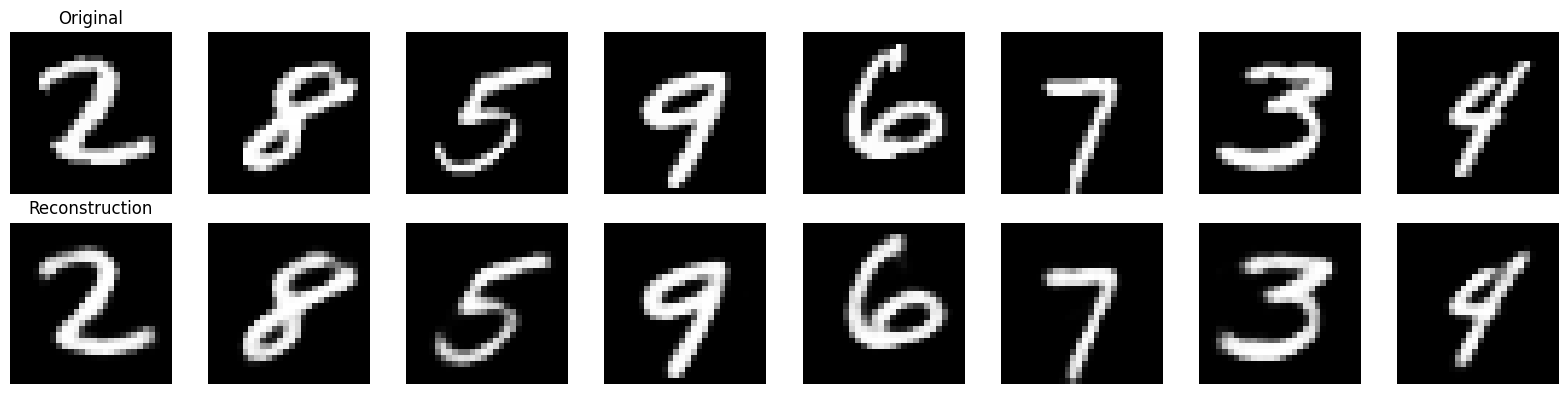

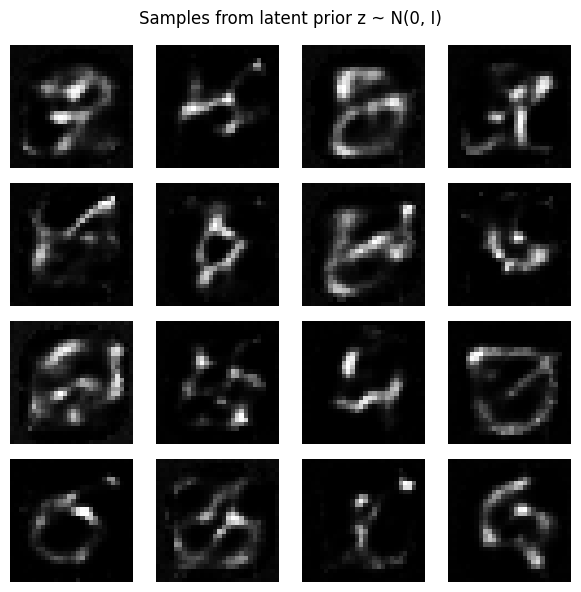

In [23]:
vis_reconstruction(vae_model, randomize=True)
vis_samples(vae_model)

## Tweaking the loss function $\beta$ [2 pt]
Prob1-6: Let's repeat the same experiment for $\beta = 10$, a very high value for the coefficient.

Running 10 epochs with beta=10.0
Run Epoch 0
Epoch 0 | rec: 0.068971 | kl: 0.000480
Run Epoch 1
Epoch 1 | rec: 0.067592 | kl: 0.000004
Run Epoch 2
Epoch 2 | rec: 0.067509 | kl: 0.000002
Run Epoch 3
Epoch 3 | rec: 0.067451 | kl: 0.000001
Run Epoch 4
Epoch 4 | rec: 0.067402 | kl: 0.000001
Run Epoch 5
Epoch 5 | rec: 0.067367 | kl: 0.000001
Run Epoch 6
Epoch 6 | rec: 0.067346 | kl: 0.000001
Run Epoch 7
Epoch 7 | rec: 0.067330 | kl: 0.000001
Run Epoch 8
Epoch 8 | rec: 0.067317 | kl: 0.000001
Run Epoch 9
Epoch 9 | rec: 0.067312 | kl: 0.000000
Done!


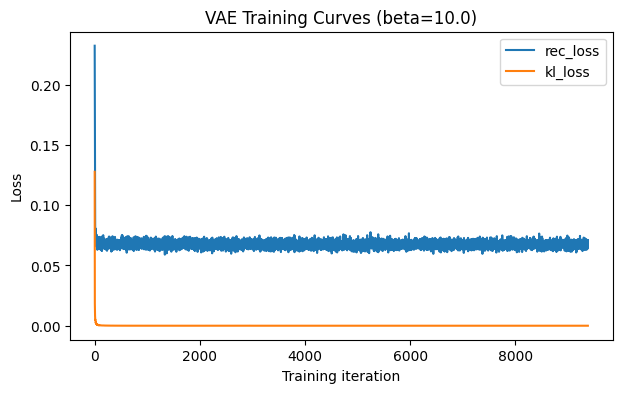

In [24]:
# TODO# Prob1-6: Train a VAE with a high beta value (beta = 10)

learning_rate = 1e-3
nz = 32
beta = 10.0
epochs = 10

vae_model_b10 = VAE(nz, beta).to(device)
vae_model_b10 = vae_model_b10.train()

optimizer = torch.optim.Adam(vae_model_b10.parameters(), lr=learning_rate)

train_it = 0
rec_loss, kl_loss = [], []
print(f"Running {epochs} epochs with {beta=}")

for ep in range(epochs):
    print("Run Epoch {}".format(ep))

    running_rec = 0.0
    running_kl = 0.0

    for data, _ in mnist_data_loader:
        data = data.to(device)

        optimizer.zero_grad()
        outputs = vae_model_b10(data)
        loss, losses = vae_model_b10.loss(data, outputs)

        loss.backward()
        optimizer.step()

        rec_loss.append(losses['rec_loss'].detach())
        kl_loss.append(losses['kl_loss'].detach())

        running_rec += losses['rec_loss'].item()
        running_kl += losses['kl_loss'].item()
        train_it += 1

    avg_rec = running_rec / len(mnist_data_loader)
    avg_kl = running_kl / len(mnist_data_loader)
    print(f"Epoch {ep} | rec: {avg_rec:.6f} | kl: {avg_kl:.6f}")

print("Done!")

# log the loss training curves
rec_loss_plotdata = [x.detach().cpu() for x in rec_loss]
kl_loss_plotdata = [x.detach().cpu() for x in kl_loss]

import matplotlib.pyplot as plt
plt.figure(figsize=(7,4))
plt.plot(rec_loss_plotdata, label="rec_loss")
plt.plot(kl_loss_plotdata, label="kl_loss")
plt.xlabel("Training iteration")
plt.ylabel("Loss")
plt.legend()
plt.title(f"VAE Training Curves (beta={beta})")
plt.show()

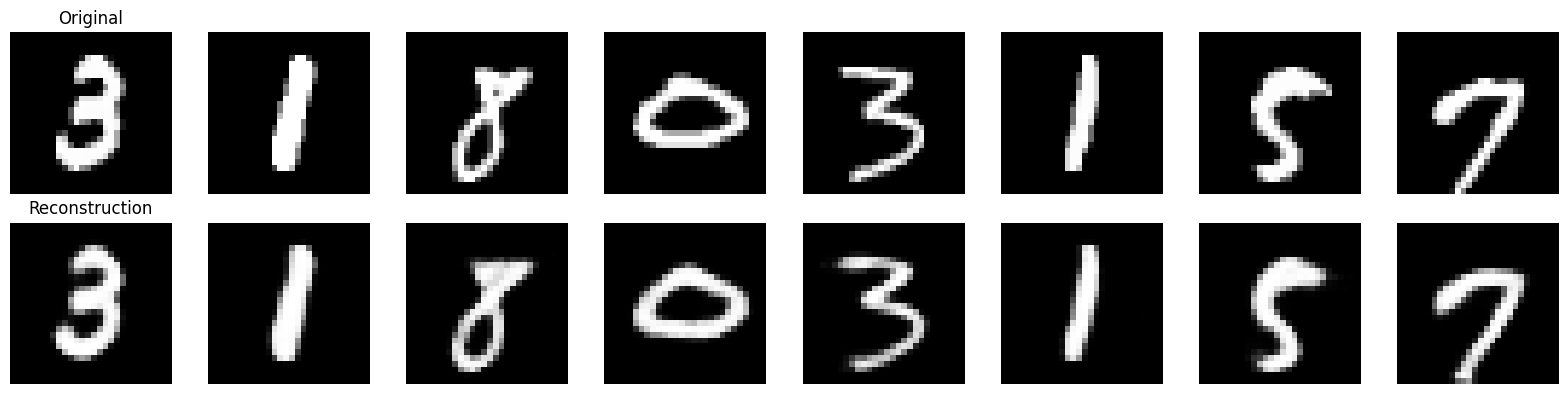

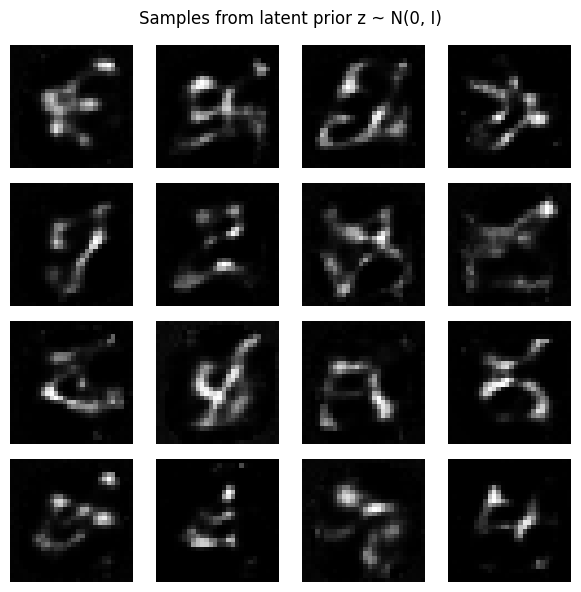

In [25]:
vis_reconstruction(vae_model, randomize=True)
vis_samples(vae_model)

>**Inline Question: What can you observe when setting $\beta = 0$ and $\beta = 10$? Explain your observations! [3 pt]**


When **β = 0**, the VAE behaves similarly to a standard auto-encoder. Reconstructions are very accurate and closely match the input images, since the training objective focuses entirely on minimizing the reconstruction loss. However, samples generated by decoding latent vectors drawn from a unit Gaussian are poor and often do not resemble valid digits, because the latent space is not regularized to follow the prior distribution.

When **β = 10**, the KL-divergence term strongly regularizes the latent space and enforces alignment with the unit Gaussian prior. As a result, random samples from the prior decode into more digit-like images. However, this comes at the cost of reconstruction quality: reconstructed images become slightly blurrier and lose fine details because the latent space has lower information capacity.

Overall, increasing β trades reconstruction fidelity for a more structured and generative latent space.


## Obtaining the best $\beta$-factor[7 pt]
Prob 1-6 continued: Now we can start tuning the beta value to achieve a good result. First describe what a "good result" would look like (focus what you would expect for reconstructions and sample quality).

>**Inline Question: Characterize what properties you would expect for reconstructions and samples of a well-tuned VAE! [3pt]**


A well-tuned VAE should achieve a good trade-off between **reconstruction fidelity** and **generative sample quality**:

- **Reconstructions:** The reconstructed images should closely match the input digits on both train and test data (correct digit identity and overall stroke structure), with only mild blur or smoothing. Reconstructions should not collapse to an “average digit” and should not lose the digit class.

- **Samples from the prior (z ~ N(0, I)):** Randomly generated samples should look like valid MNIST digits most of the time (recognizable and distinguishable numbers). They should be **diverse** (different digit classes and different writing styles), and should not all look identical (no mode collapse). The background should remain mostly clean without heavy noise artifacts.

Now that you know what outcome we would like to obtain, try to tune $\beta$ to achieve this result. Logarithmic search in steps of 10x will be helpful, good results can be achieved after ~20 epochs of training. Training reconstructions should be high quality, test samples should be diverse, distinguishable numbers, most samples recognizable as numbers.



[beta=0.001] epoch 00 | rec=0.05011 | kl=5.01772
[beta=0.001] epoch 01 | rec=0.03132 | kl=9.05116
[beta=0.001] epoch 02 | rec=0.02795 | kl=9.80654
[beta=0.001] epoch 03 | rec=0.02639 | kl=10.15317
[beta=0.001] epoch 04 | rec=0.02529 | kl=10.40374
[beta=0.001] epoch 05 | rec=0.02448 | kl=10.60655
[beta=0.001] epoch 06 | rec=0.02388 | kl=10.74740
[beta=0.001] epoch 07 | rec=0.02335 | kl=10.87307
[beta=0.001] epoch 08 | rec=0.02295 | kl=10.97744
[beta=0.001] epoch 09 | rec=0.02261 | kl=11.04081
[beta=0.001] epoch 10 | rec=0.02234 | kl=11.11910
[beta=0.001] epoch 11 | rec=0.02210 | kl=11.19114
[beta=0.001] epoch 12 | rec=0.02188 | kl=11.22989
[beta=0.001] epoch 13 | rec=0.02168 | kl=11.27343
[beta=0.001] epoch 14 | rec=0.02152 | kl=11.31993
[beta=0.001] epoch 15 | rec=0.02141 | kl=11.34743
[beta=0.001] epoch 16 | rec=0.02126 | kl=11.36845
[beta=0.001] epoch 17 | rec=0.02116 | kl=11.41143
[beta=0.001] epoch 18 | rec=0.02102 | kl=11.44314
[beta=0.001] epoch 19 | rec=0.02093 | kl=11.47117

Q

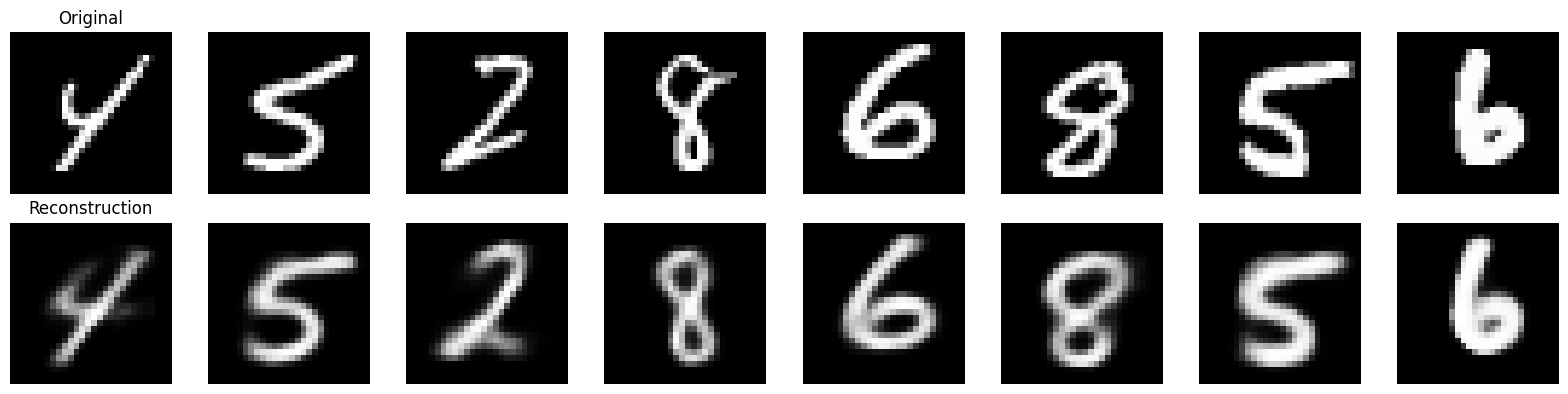

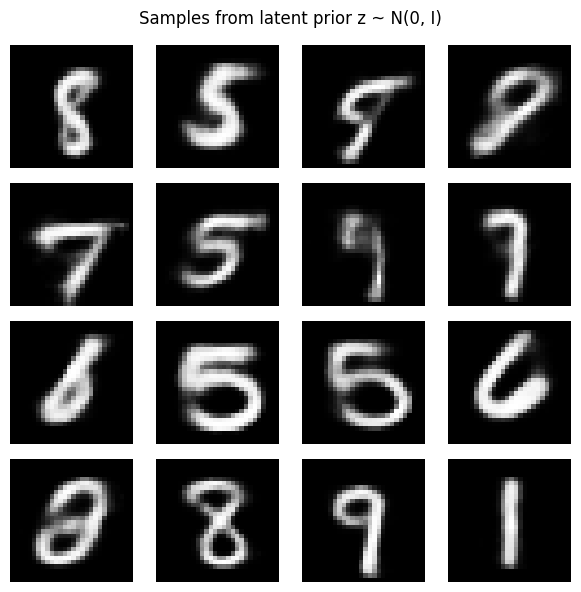


[beta=0.01] epoch 00 | rec=0.06855 | kl=0.02885
[beta=0.01] epoch 01 | rec=0.06653 | kl=0.09256
[beta=0.01] epoch 02 | rec=0.06618 | kl=0.11807
[beta=0.01] epoch 03 | rec=0.06599 | kl=0.12461
[beta=0.01] epoch 04 | rec=0.06596 | kl=0.12436
[beta=0.01] epoch 05 | rec=0.06585 | kl=0.13035
[beta=0.01] epoch 06 | rec=0.06566 | kl=0.14465
[beta=0.01] epoch 07 | rec=0.06542 | kl=0.15881
[beta=0.01] epoch 08 | rec=0.06488 | kl=0.20313
[beta=0.01] epoch 09 | rec=0.06441 | kl=0.24138
[beta=0.01] epoch 10 | rec=0.06434 | kl=0.24954
[beta=0.01] epoch 11 | rec=0.06423 | kl=0.25353
[beta=0.01] epoch 12 | rec=0.06424 | kl=0.25416
[beta=0.01] epoch 13 | rec=0.06423 | kl=0.25411
[beta=0.01] epoch 14 | rec=0.06423 | kl=0.25719
[beta=0.01] epoch 15 | rec=0.06415 | kl=0.26108
[beta=0.01] epoch 16 | rec=0.06419 | kl=0.25802
[beta=0.01] epoch 17 | rec=0.06414 | kl=0.26132
[beta=0.01] epoch 18 | rec=0.06422 | kl=0.25437
[beta=0.01] epoch 19 | rec=0.06421 | kl=0.25696

Qualitative check for beta=0.01


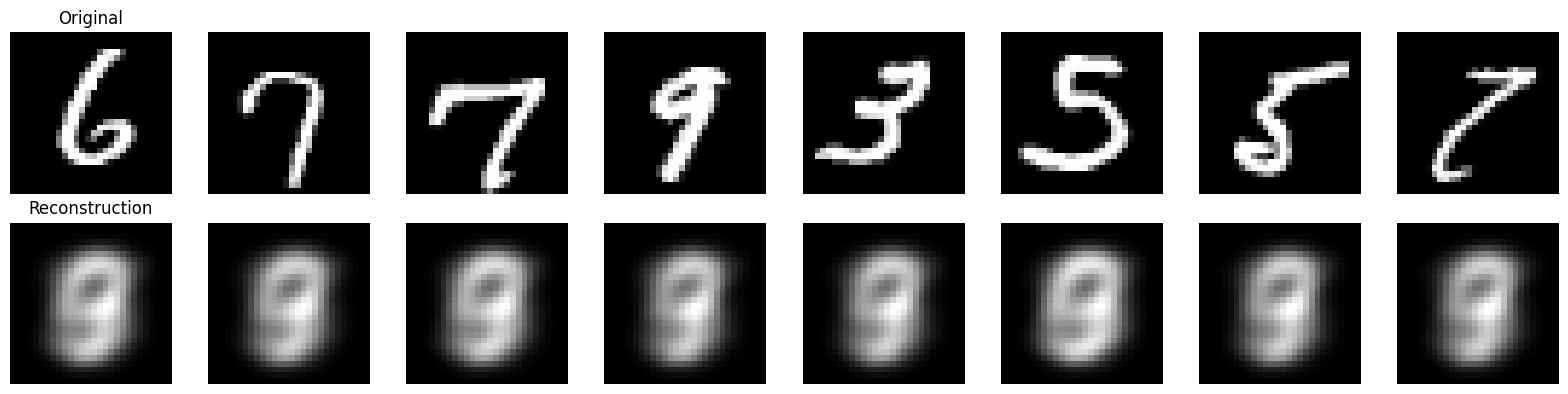

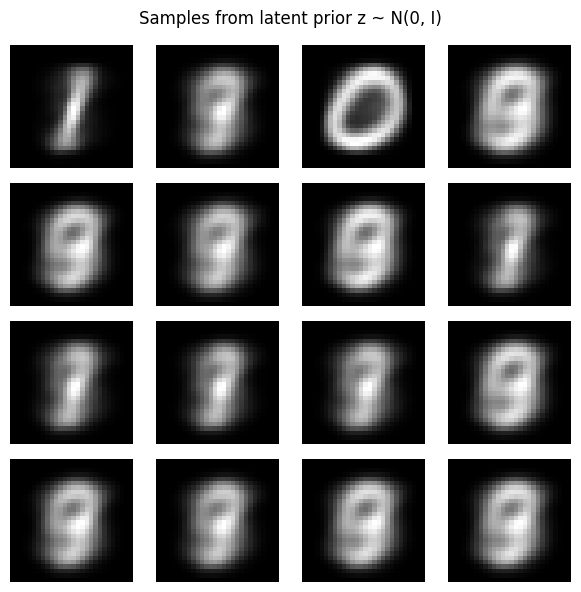


[beta=0.1] epoch 00 | rec=0.06898 | kl=0.00061
[beta=0.1] epoch 01 | rec=0.06758 | kl=0.00005
[beta=0.1] epoch 02 | rec=0.06750 | kl=0.00003
[beta=0.1] epoch 03 | rec=0.06744 | kl=0.00002
[beta=0.1] epoch 04 | rec=0.06740 | kl=0.00001
[beta=0.1] epoch 05 | rec=0.06735 | kl=0.00001
[beta=0.1] epoch 06 | rec=0.06734 | kl=0.00001
[beta=0.1] epoch 07 | rec=0.06733 | kl=0.00001
[beta=0.1] epoch 08 | rec=0.06731 | kl=0.00001
[beta=0.1] epoch 09 | rec=0.06731 | kl=0.00001
[beta=0.1] epoch 10 | rec=0.06730 | kl=0.00001
[beta=0.1] epoch 11 | rec=0.06729 | kl=0.00001
[beta=0.1] epoch 12 | rec=0.06730 | kl=0.00000
[beta=0.1] epoch 13 | rec=0.06729 | kl=0.00000
[beta=0.1] epoch 14 | rec=0.06729 | kl=0.00000
[beta=0.1] epoch 15 | rec=0.06729 | kl=0.00000
[beta=0.1] epoch 16 | rec=0.06729 | kl=0.00000
[beta=0.1] epoch 17 | rec=0.06728 | kl=0.00000
[beta=0.1] epoch 18 | rec=0.06728 | kl=0.00000
[beta=0.1] epoch 19 | rec=0.06728 | kl=0.00000

Qualitative check for beta=0.1


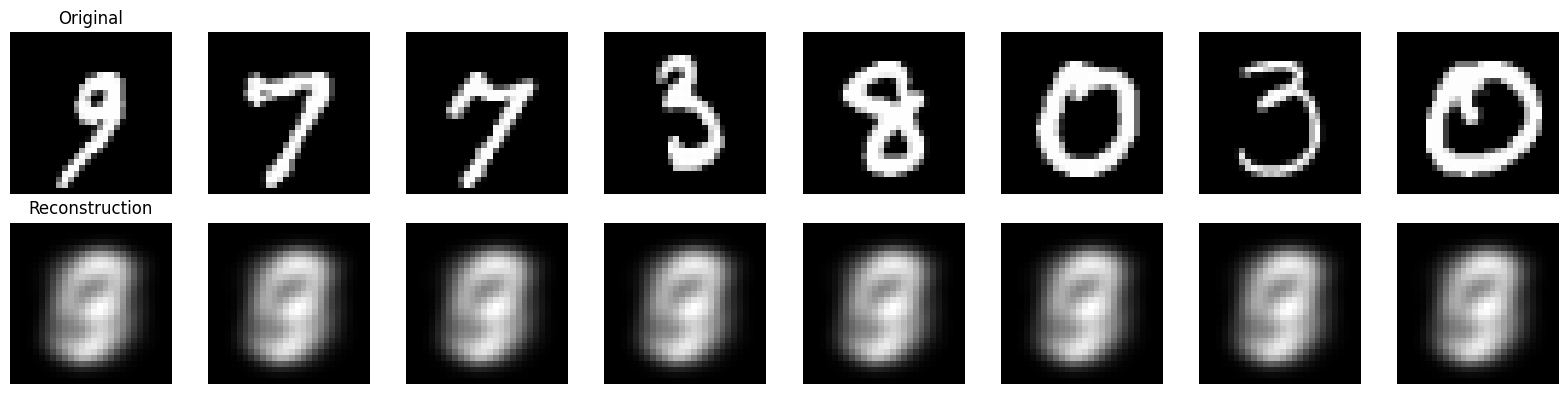

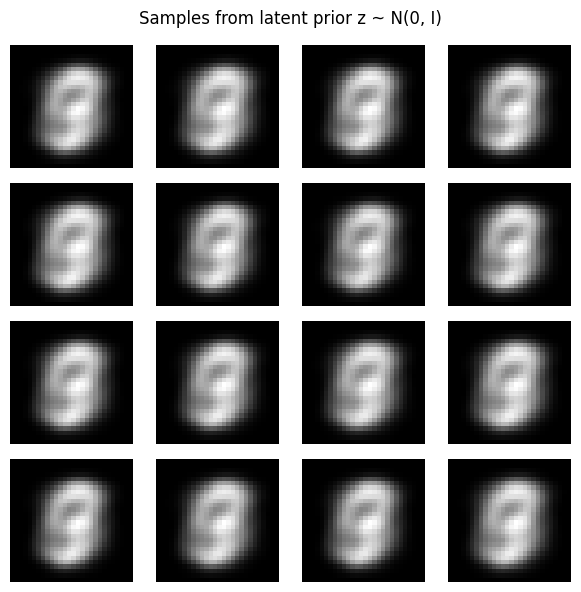


[beta=1.0] epoch 00 | rec=0.06898 | kl=0.00040
[beta=1.0] epoch 01 | rec=0.06759 | kl=0.00000
[beta=1.0] epoch 02 | rec=0.06752 | kl=0.00000
[beta=1.0] epoch 03 | rec=0.06744 | kl=0.00000
[beta=1.0] epoch 04 | rec=0.06740 | kl=0.00000
[beta=1.0] epoch 05 | rec=0.06737 | kl=0.00000
[beta=1.0] epoch 06 | rec=0.06734 | kl=0.00000
[beta=1.0] epoch 07 | rec=0.06732 | kl=0.00000
[beta=1.0] epoch 08 | rec=0.06732 | kl=0.00001
[beta=1.0] epoch 09 | rec=0.06731 | kl=0.00000
[beta=1.0] epoch 10 | rec=0.06730 | kl=0.00000
[beta=1.0] epoch 11 | rec=0.06730 | kl=0.00000
[beta=1.0] epoch 12 | rec=0.06729 | kl=0.00000
[beta=1.0] epoch 13 | rec=0.06729 | kl=0.00000
[beta=1.0] epoch 14 | rec=0.06729 | kl=0.00000
[beta=1.0] epoch 15 | rec=0.06729 | kl=0.00000
[beta=1.0] epoch 16 | rec=0.06728 | kl=0.00000
[beta=1.0] epoch 17 | rec=0.06729 | kl=0.00000
[beta=1.0] epoch 18 | rec=0.06728 | kl=0.00000
[beta=1.0] epoch 19 | rec=0.06728 | kl=0.00000

Qualitative check for beta=1.0


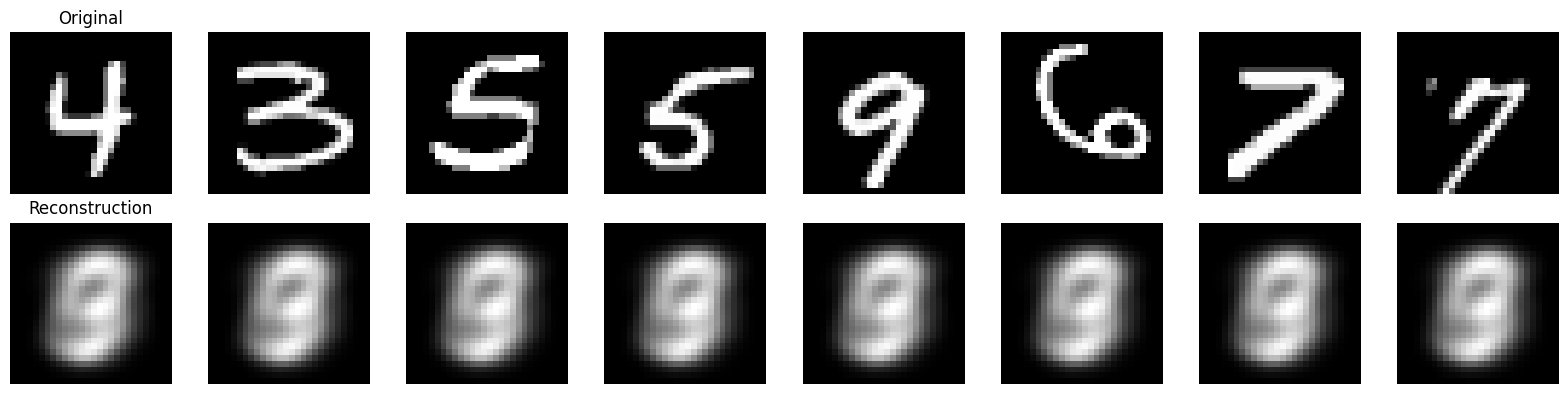

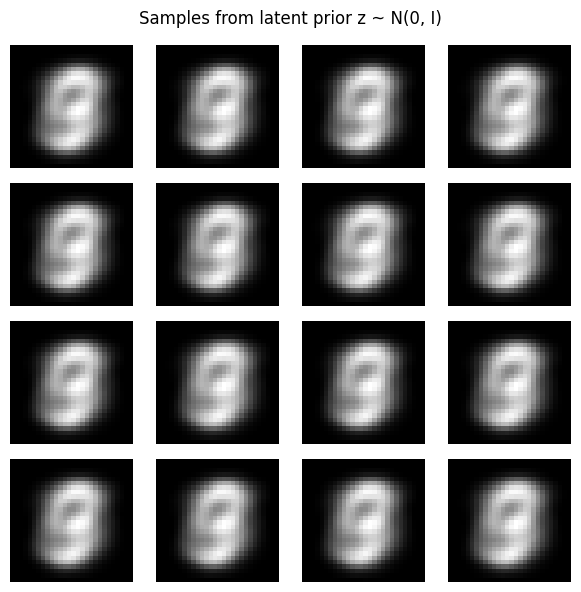


[beta=10.0] epoch 00 | rec=0.06901 | kl=0.00043
[beta=10.0] epoch 01 | rec=0.06759 | kl=0.00000
[beta=10.0] epoch 02 | rec=0.06750 | kl=0.00000
[beta=10.0] epoch 03 | rec=0.06746 | kl=0.00000
[beta=10.0] epoch 04 | rec=0.06740 | kl=0.00000
[beta=10.0] epoch 05 | rec=0.06737 | kl=0.00000
[beta=10.0] epoch 06 | rec=0.06734 | kl=0.00000
[beta=10.0] epoch 07 | rec=0.06733 | kl=0.00000
[beta=10.0] epoch 08 | rec=0.06732 | kl=0.00000
[beta=10.0] epoch 09 | rec=0.06731 | kl=0.00000
[beta=10.0] epoch 10 | rec=0.06731 | kl=0.00000
[beta=10.0] epoch 11 | rec=0.06731 | kl=0.00000
[beta=10.0] epoch 12 | rec=0.06730 | kl=0.00000
[beta=10.0] epoch 13 | rec=0.06729 | kl=0.00000
[beta=10.0] epoch 14 | rec=0.06729 | kl=0.00000
[beta=10.0] epoch 15 | rec=0.06729 | kl=0.00000
[beta=10.0] epoch 16 | rec=0.06729 | kl=0.00000
[beta=10.0] epoch 17 | rec=0.06729 | kl=0.00000
[beta=10.0] epoch 18 | rec=0.06729 | kl=0.00000
[beta=10.0] epoch 19 | rec=0.06728 | kl=0.00000

Qualitative check for beta=10.0


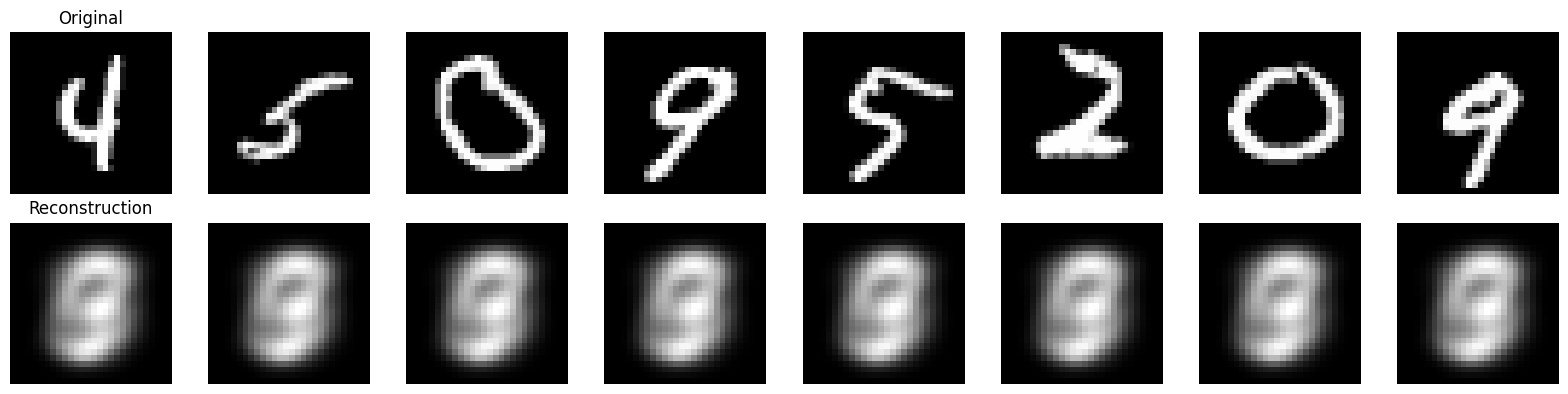

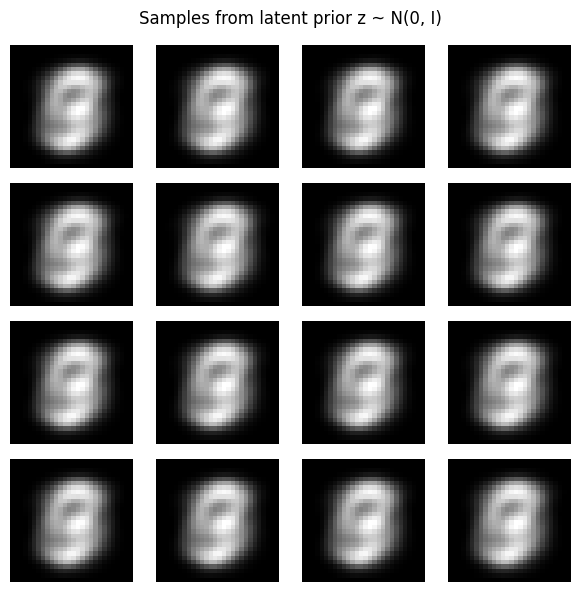

In [26]:
import torch
import matplotlib.pyplot as plt

def train_vae_for_beta(beta, nz=32, epochs=20, lr=1e-3):
    model = VAE(nz, beta).to(device).train()
    opt = torch.optim.Adam(model.parameters(), lr=lr)

    rec_hist, kl_hist = [], []
    for ep in range(epochs):
        running_rec, running_kl = 0.0, 0.0
        for x, _ in mnist_data_loader:
            x = x.to(device)
            opt.zero_grad()
            out = model(x)
            loss, losses = model.loss(x, out)
            loss.backward()
            opt.step()

            running_rec += losses["rec_loss"].item()
            running_kl += losses["kl_loss"].item()

        rec_hist.append(running_rec / len(mnist_data_loader))
        kl_hist.append(running_kl / len(mnist_data_loader))
        print(f"[beta={beta}] epoch {ep:02d} | rec={rec_hist[-1]:.5f} | kl={kl_hist[-1]:.5f}")

    return model, rec_hist, kl_hist

# 10x logarithmic sweep
betas_to_try = [0.001, 0.01, 0.1, 1.0, 10.0]
trained_models = {}

for b in betas_to_try:
    print("\n" + "="*60)
    model_b, rec_h, kl_h = train_vae_for_beta(beta=b, nz=32, epochs=20, lr=1e-3)
    trained_models[b] = (model_b, rec_h, kl_h)

    # quick qualitative check
    print(f"\nQualitative check for beta={b}")
    vis_reconstruction(model_b, randomize=True)
    vis_samples(model_b)

# Pick the best beta based on reconstructions + sample quality
best_beta = None  # set this manually after inspecting results

BEST beta =  0.01


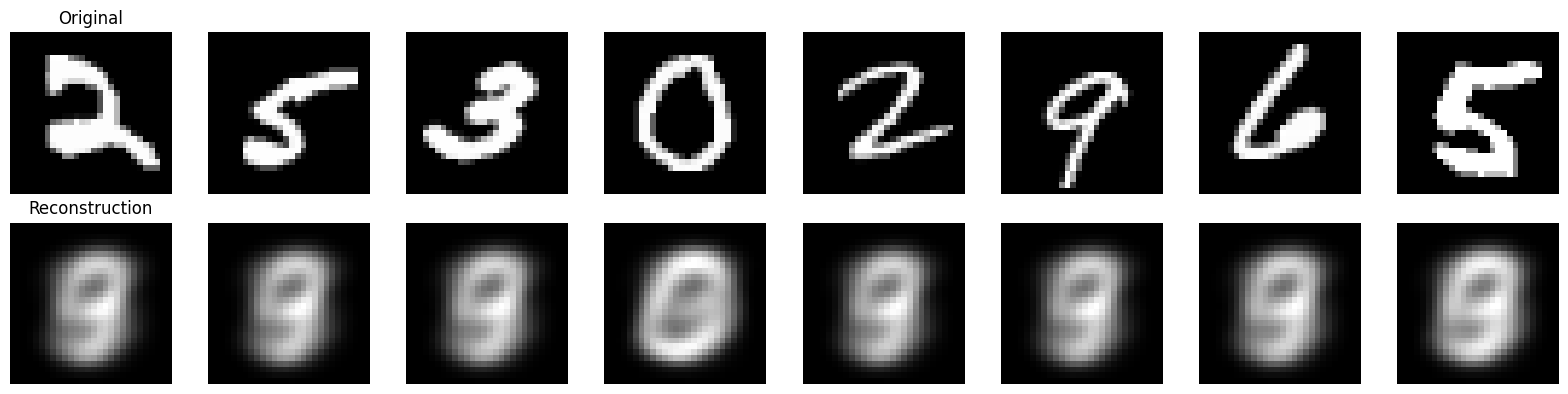

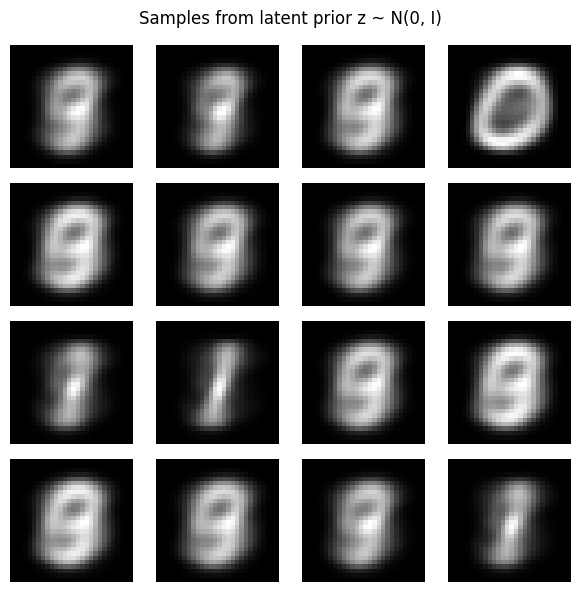

In [27]:
# Set best beta based on tuning
beta = 0.01
print("BEST beta = ", beta)

# Re-train (or reuse if already trained with beta=0.01)
vae_model = VAE(nz=32, beta=beta).to(device)
vae_model = vae_model.train()

optimizer = torch.optim.Adam(vae_model.parameters(), lr=1e-3)
epochs = 20

for ep in range(epochs):
    for data, _ in mnist_data_loader:
        data = data.to(device)
        optimizer.zero_grad()
        outputs = vae_model(data)
        loss, _ = vae_model.loss(data, outputs)
        loss.backward()
        optimizer.step()

# Visualize results
vis_reconstruction(vae_model, randomize=True)
vis_samples(vae_model)

# 4. Embedding Space Interpolation[8 pt]

As mentioned in the introduction, AEs and VAEs cannot only be used to generate images, but also to learn low-dimensional representations of their inputs. In this final section we will investigate the representations we learned with both models by **interpolating in embedding space** between different images. We will encode two images into their low-dimensional embedding representations, then interpolate these embeddings and reconstruct the result.

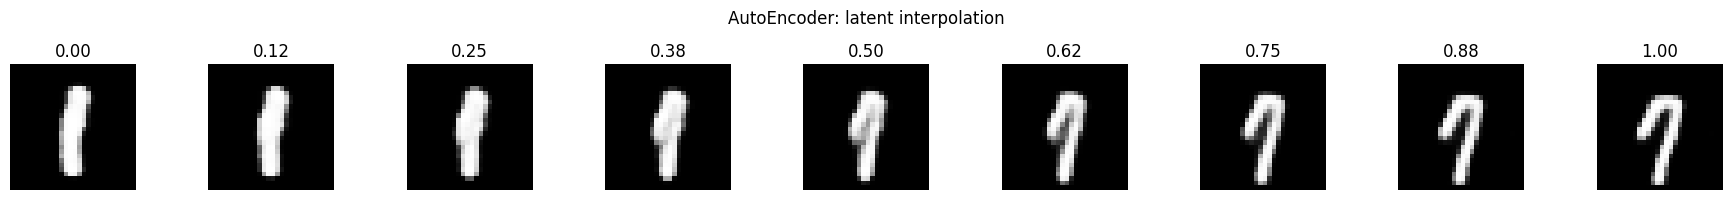

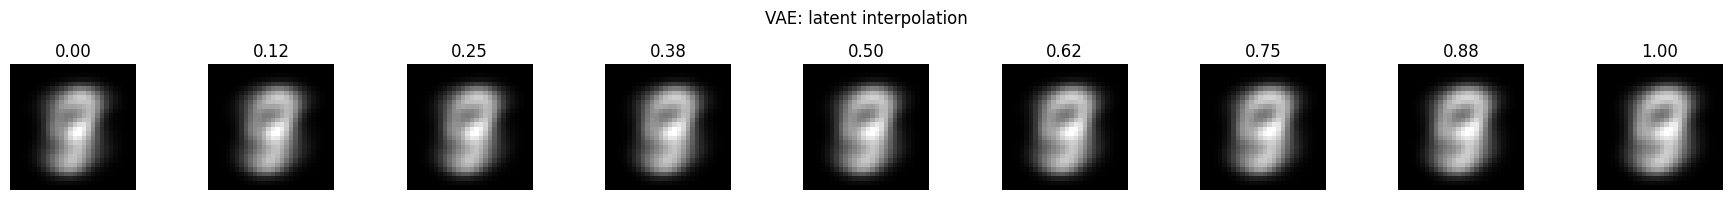

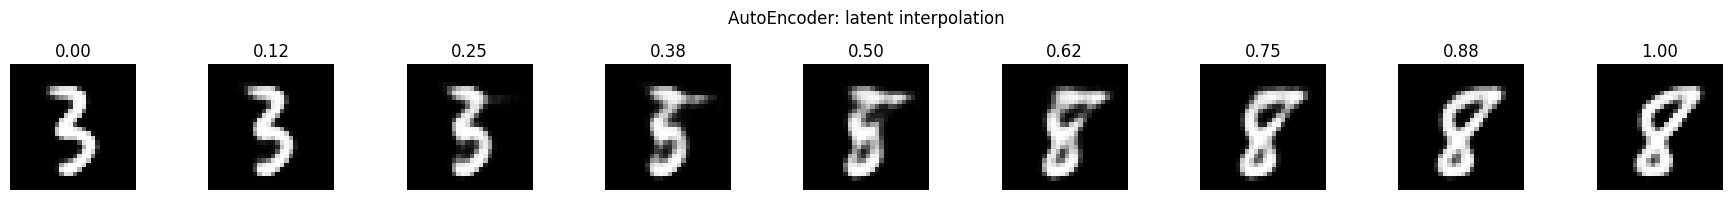

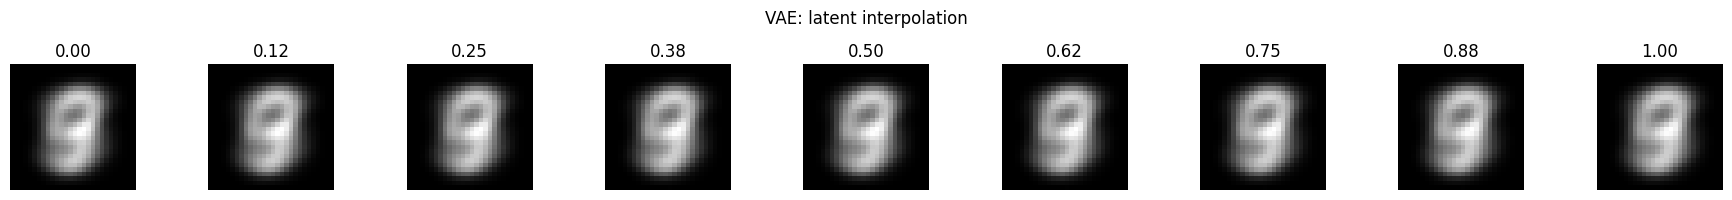

In [28]:
import torch
import matplotlib.pyplot as plt

nz = 32

def get_image_with_label(target_label):
  """Returns a random image from the training set with the requested digit."""
  while True:
    idx = torch.randint(0, len(mnist_train), (1,)).item()
    img, label = mnist_train[idx]
    if label == target_label:
      return img.to(device)

def interpolate_and_visualize(model, tag, start_img, end_img):
  """Encodes images and performs interpolation. Displays decodings."""
  model.eval()
  device = next(model.parameters()).device

  # ensure batch dimension
  start_img = start_img.unsqueeze(0).to(device)  # (1,1,28,28)
  end_img   = end_img.unsqueeze(0).to(device)    # (1,1,28,28)

  # get embeddings (handle AE vs VAE)
  with torch.no_grad():
    if isinstance(model, AutoEncoder) or hasattr(model, "encoder"):
      z0 = model.encoder(start_img)         # (1,nz)
      z1 = model.encoder(end_img)           # (1,nz)
      decode_fn = model.decoder
    else:
      # VAE: use posterior mean for stable interpolation
      h0 = model.enc(start_img)
      h1 = model.enc(end_img)
      z0 = model.enc_mu(h0)                 # (1,nz)
      z1 = model.enc_mu(h1)                 # (1,nz)
      decode_fn = model.dec

    # interpolate
    n_steps = 9
    alphas = torch.linspace(0, 1, n_steps, device=device)

    zs = torch.cat([(1 - a) * z0 + a * z1 for a in alphas], dim=0)  # (n_steps,nz)
    imgs = decode_fn(zs)  # (n_steps,1,28,28) OR (n_steps,784)

    # reshape if needed
    if imgs.dim() == 2 and imgs.shape[-1] == 28 * 28:
      imgs = imgs.view(-1, 1, 28, 28)
    if imgs.dim() == 3 and imgs.shape[-1] == 28 * 28:
      imgs = imgs.view(-1, 1, 28, 28)

  # plot
  fig, axes = plt.subplots(1, n_steps, figsize=(2*n_steps, 2))
  for i in range(n_steps):
    axes[i].imshow(imgs[i].detach().cpu().squeeze(), cmap="gray")
    axes[i].axis("off")
    axes[i].set_title(f"{alphas[i].item():.2f}")
  plt.suptitle(f"{tag}: latent interpolation")
  plt.tight_layout()
  plt.show()

  model.train()


### Interpolation 1
START_LABEL = 1
END_LABEL = 7

start_img = get_image_with_label(START_LABEL)
end_img = get_image_with_label(END_LABEL)

interpolate_and_visualize(ae_model, "AutoEncoder", start_img, end_img)
interpolate_and_visualize(vae_model, "VAE", start_img, end_img)


### Interpolation 2
START_LABEL = 3
END_LABEL = 8

start_img = get_image_with_label(START_LABEL)
end_img = get_image_with_label(END_LABEL)

interpolate_and_visualize(ae_model, "AutoEncoder", start_img, end_img)
interpolate_and_visualize(vae_model, "VAE", start_img, end_img)

Repeat the experiment for different start / end labels and different samples. Describe your observations.

>**Inline Question: Repeat the interpolation experiment with different start / end labels and multiple samples. Describe your observations! [5 pt]**
>  1. How do AE and VAE embedding space interpolations differ?
>  2. How do you expect these differences to affect the usefulness of the learned representation for downstream learning?


We repeated the interpolation experiments for multiple start/end digit pairs (e.g., 1→7, 3→8, 0→9) and different randomly sampled images of the same labels.

**1. Differences between AE and VAE interpolations**

For the **auto-encoder (AE)**, interpolations in latent space often produce unrealistic or distorted intermediate images. While the start and end points usually reconstruct correctly, the intermediate steps may show abrupt transitions, broken strokes, or images that do not resemble valid digits. This suggests that the AE’s latent space is irregular and not globally smooth; interpolated latent vectors can pass through regions that were not well represented during training.

In contrast, the **variational auto-encoder (VAE)** produces much smoother and more meaningful interpolations. Intermediate reconstructions gradually morph from one digit to another, maintaining digit-like structure throughout the interpolation. This indicates that the VAE learns a more continuous and structured latent space, where nearby points correspond to semantically similar images.

**2. Implications for downstream learning**

These differences make the VAE’s learned representation more useful for downstream tasks. A smooth and well-organized latent space enables better generalization, interpolation, and robustness, which are beneficial for tasks such as clustering, classification, and controlled generation. The AE’s less structured latent space may work well for reconstruction but is less reliable for tasks that require meaningful distances or linear operations in the embedding space.

Overall, the VAE’s regularized latent space leads to representations that better capture the underlying data manifold and are more suitable for downstream learning.


# 5. Conditional VAE[10 pt]
Let us now try a Conditional VAE
Now we will try to create a [Conditional VAE](https://proceedings.neurips.cc/paper/2014/file/d523773c6b194f37b938d340d5d02232-Paper.pdf), where we can condition the encoder and decoder of the VAE on the label `c`.

## Defining the conditional Encoder, Decoder, and VAE models [7 pt]

Prob1-8. We create a separate encoder and decoder class that take in an additional argument `c` in their forward pass, and then build our CVAE model on top of it. Note that the encoder and decoder just need to append `c` to the standard inputs to these modules.

In [29]:
import torch
import torch.nn as nn
import torch.nn.functional as F

def idx2onehot(idx, n):
    """Converts a batch of indices to a one-hot representation."""
    # idx: (B,) integer labels
    if idx.dim() == 2 and idx.size(1) == 1:
        idx = idx.squeeze(1)
    onehot = torch.zeros(idx.size(0), n, device=idx.device)
    onehot.scatter_(1, idx.long().view(-1, 1), 1.0)
    return onehot

# Define encoder and decoder networks

class CVAEEncoder(nn.Module):
  def __init__(self, nz, input_size, conditional, num_labels):
    super().__init__()
    self.input_size = input_size + num_labels if conditional else input_size
    self.num_labels = num_labels
    self.conditional = conditional

    # shared trunk
    self.net = nn.Sequential(
        nn.Flatten(),
        nn.Linear(self.input_size, 512),
        nn.ReLU(inplace=True),
        nn.Linear(512, 256),
        nn.ReLU(inplace=True),
    )
    # posterior params
    self.mu = nn.Linear(256, nz)
    self.log_sigma = nn.Linear(256, nz)

  def forward(self, x, c=None):
    # x can be (B,1,28,28) or (B,784); ensure (B,784)
    if x.dim() > 2:
        x = x.view(x.size(0), -1)

    if self.conditional:
        assert c is not None, "Conditional encoder requires c"
        if c.dim() == 1:
            c = idx2onehot(c, self.num_labels)
        x = torch.cat([x, c], dim=1)

    h = self.net(x)
    mu = self.mu(h)
    log_sigma = self.log_sigma(h)
    return {'mu': mu, 'log_sigma': log_sigma}


class CVAEDecoder(nn.Module):
  def __init__(self, nz, output_size, conditional, num_labels):
    super().__init__()
    self.output_size = output_size
    self.conditional = conditional
    self.num_labels = num_labels
    if self.conditional:
        nz = nz + num_labels

    self.net = nn.Sequential(
        nn.Linear(nz, 256),
        nn.ReLU(inplace=True),
        nn.Linear(256, 512),
        nn.ReLU(inplace=True),
        nn.Linear(512, output_size),
        nn.Sigmoid()
    )

  def forward(self, z, c=None):
    if self.conditional:
        assert c is not None, "Conditional decoder requires c"
        if c.dim() == 1:
            c = idx2onehot(c, self.num_labels)
        z = torch.cat([z, c], dim=1)

    return self.net(z).reshape(-1, 1, self.output_size)


class CVAE(nn.Module):
    def __init__(self, nz, beta=1.0, conditional=False, num_labels=0):
        super().__init__()
        if conditional:
            assert num_labels > 0
        self.beta = beta
        self.nz = nz
        self.conditional = conditional
        self.num_labels = num_labels

        in_size = out_size = 28 * 28
        self.encoder = CVAEEncoder(nz=nz, input_size=in_size,
                                  conditional=conditional, num_labels=num_labels)
        self.decoder = CVAEDecoder(nz=nz, output_size=out_size,
                                  conditional=conditional, num_labels=num_labels)

    def forward(self, x, c=None):
        enc_out = self.encoder(x, c)
        mu = enc_out['mu']
        log_sigma = enc_out['log_sigma']

        eps = torch.randn_like(mu)
        z = mu + torch.exp(log_sigma) * eps

        reconstruction = self.decoder(z, c)

        q = {'mu': mu, 'log_sigma': log_sigma, 'z': z}
        return {'q': q, 'rec': reconstruction, 'c': c}

    def loss(self, x, outputs):
        rec = outputs['rec']
        q = outputs['q']

        # ensure x is shaped like rec: (B,1,784)
        if x.dim() > 2:
            x_flat = x.view(x.size(0), -1)
        else:
            x_flat = x
        x_flat = x_flat.view(-1, 1, 28*28)

        rec_loss = F.mse_loss(rec, x_flat, reduction='mean')

        mu2 = torch.zeros_like(q['mu'])
        log_sigma2 = torch.zeros_like(q['log_sigma'])
        kl_per_sample = kl_divergence(q['mu'], q['log_sigma'], mu2, log_sigma2)
        kl_loss = kl_per_sample.mean()

        return rec_loss + self.beta * kl_loss, \
            {'rec_loss': rec_loss, 'kl_loss': kl_loss}

    def reconstruct(self, x, c=None):
        """Use posterior mean for visualization."""
        self.eval()
        device = next(self.parameters()).device
        with torch.no_grad():
            if x.dim() > 2:
                x_in = x.to(device)
            else:
                x_in = x.to(device).view(x.size(0), 1, 28, 28)

            enc_out = self.encoder(x_in, c)
            mu = enc_out['mu']
            image = self.decoder(mu, c)
        self.train()
        return image

## Setting up the CVAE Training loop[2 pt]

Running 20 epochs with beta=0.01
Run Epoch 0
Epoch 0 | rec: 0.057713 | kl: 0.010984
Run Epoch 1
Epoch 1 | rec: 0.053669 | kl: 0.005904
Run Epoch 2
Epoch 2 | rec: 0.053499 | kl: 0.009264
Run Epoch 3
Epoch 3 | rec: 0.053211 | kl: 0.025938
Run Epoch 4
Epoch 4 | rec: 0.053002 | kl: 0.039484
Run Epoch 5
Epoch 5 | rec: 0.052679 | kl: 0.059403
Run Epoch 6
Epoch 6 | rec: 0.052532 | kl: 0.071177
Run Epoch 7
Epoch 7 | rec: 0.052324 | kl: 0.082450
Run Epoch 8
Epoch 8 | rec: 0.051822 | kl: 0.115305
Run Epoch 9
Epoch 9 | rec: 0.051621 | kl: 0.127693
Run Epoch 10
Epoch 10 | rec: 0.051489 | kl: 0.138280
Run Epoch 11
Epoch 11 | rec: 0.051414 | kl: 0.142096
Run Epoch 12
Epoch 12 | rec: 0.051385 | kl: 0.145470
Run Epoch 13
Epoch 13 | rec: 0.051353 | kl: 0.144916
Run Epoch 14
Epoch 14 | rec: 0.051331 | kl: 0.149498
Run Epoch 15
Epoch 15 | rec: 0.051301 | kl: 0.151883
Run Epoch 16
Epoch 16 | rec: 0.051290 | kl: 0.151739
Run Epoch 17
Epoch 17 | rec: 0.051255 | kl: 0.153545
Run Epoch 18
Epoch 18 | rec: 0.05

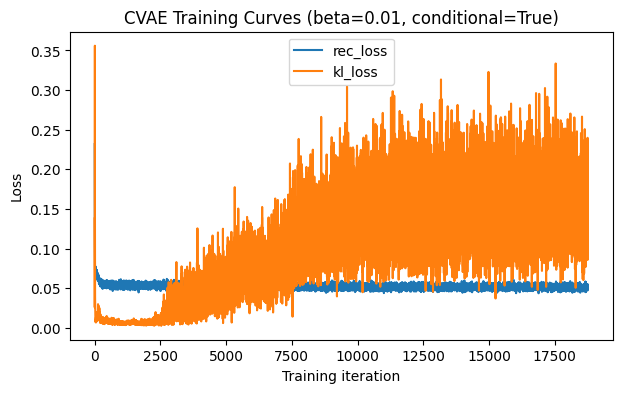

In [30]:
# Setting up the CVAE Training loop

import torch
import matplotlib.pyplot as plt

learning_rate = 1e-3
nz = 32
epochs = 20
beta = 0.01
conditional = True

cvae_model = CVAE(nz=nz, beta=beta, conditional=conditional, num_labels=10).to(device)
cvae_model = cvae_model.train()

optimizer = torch.optim.Adam(cvae_model.parameters(), lr=learning_rate)

train_it = 0
rec_loss, kl_loss = [], []
print(f"Running {epochs} epochs with {beta=}")

for ep in range(epochs):
    print(f"Run Epoch {ep}")

    running_rec = 0.0
    running_kl = 0.0

    for data, labels in mnist_data_loader:
        data = data.to(device)
        labels = labels.to(device)  # (B,)

        optimizer.zero_grad()
        outputs = cvae_model(data, c=labels)
        loss, losses = cvae_model.loss(data, outputs)

        loss.backward()
        optimizer.step()

        rec_loss.append(losses["rec_loss"].detach())
        kl_loss.append(losses["kl_loss"].detach())
        running_rec += losses["rec_loss"].item()
        running_kl += losses["kl_loss"].item()
        train_it += 1

    avg_rec = running_rec / len(mnist_data_loader)
    avg_kl = running_kl / len(mnist_data_loader)
    print(f"Epoch {ep} | rec: {avg_rec:.6f} | kl: {avg_kl:.6f}")

print("Done!")

rec_loss_plotdata = [foo.detach().cpu() for foo in rec_loss]
kl_loss_plotdata = [foo.detach().cpu() for foo in kl_loss]

# log the loss training curves
plt.figure(figsize=(7,4))
plt.plot(rec_loss_plotdata, label="rec_loss")
plt.plot(kl_loss_plotdata, label="kl_loss")
plt.xlabel("Training iteration")
plt.ylabel("Loss")
plt.legend()
plt.title(f"CVAE Training Curves (beta={beta}, conditional={conditional})")
plt.show()

### Verifying conditional samples from CVAE[1 pt]
Now let us generate samples from the trained model, conditioned on all the labels.

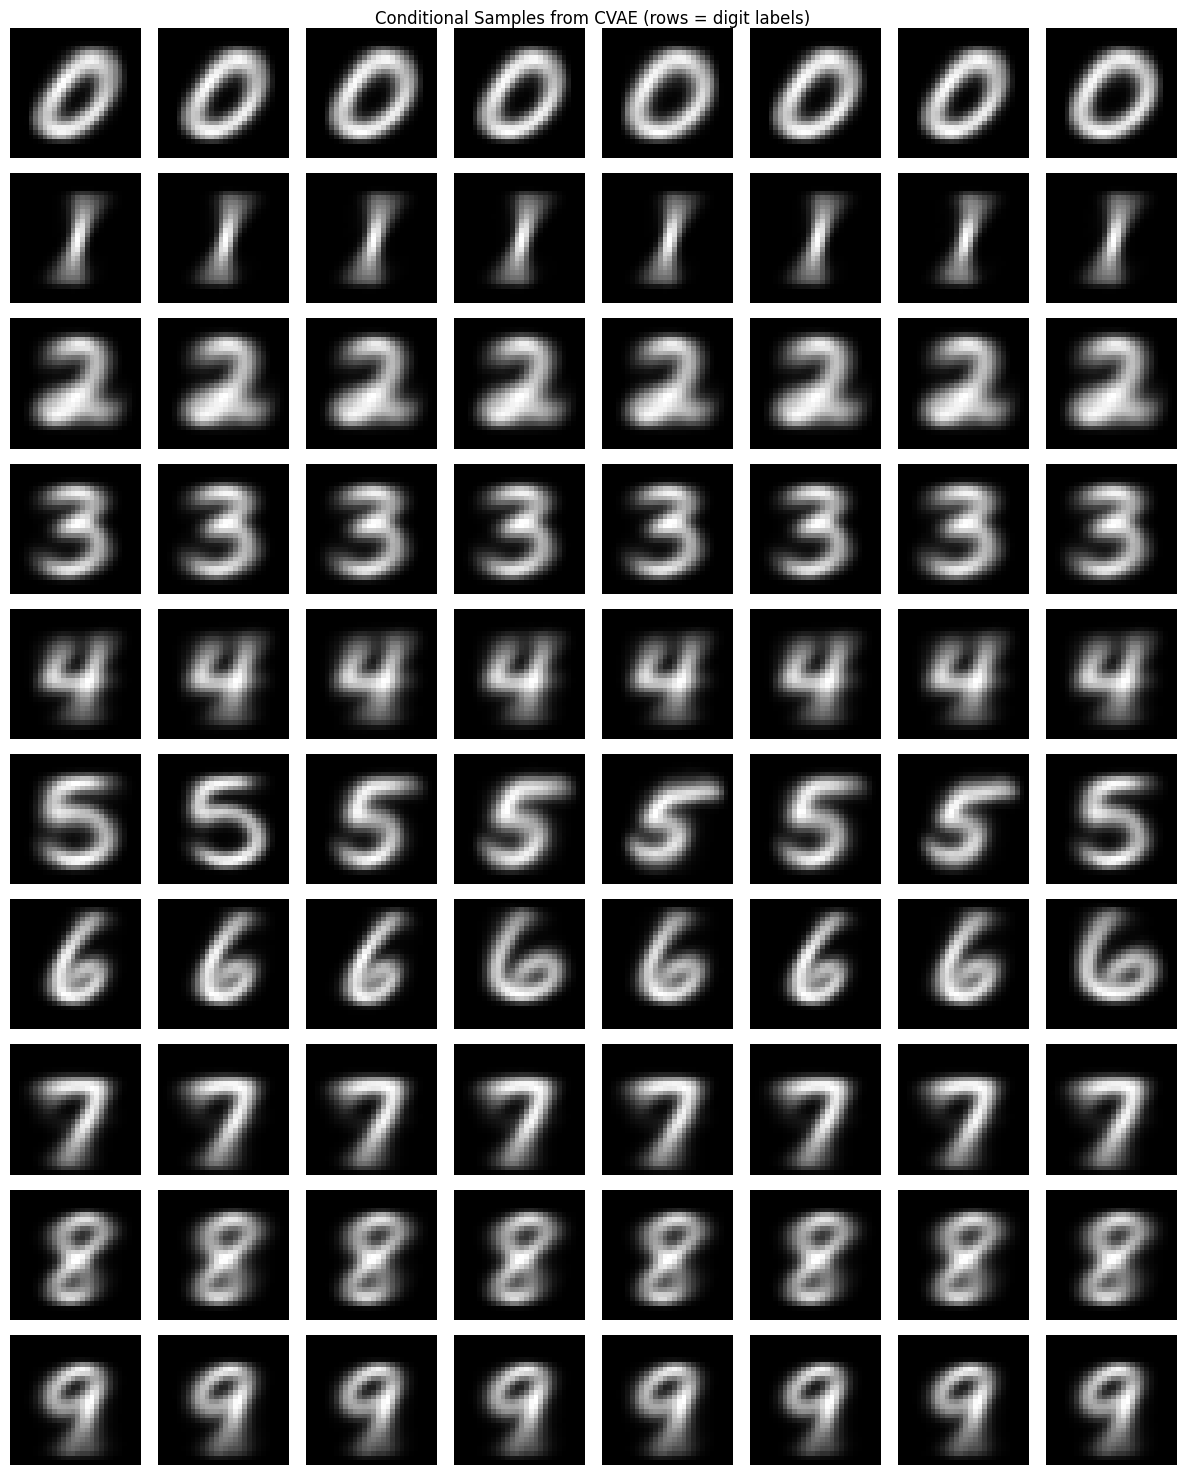

In [31]:
# Verifying conditional samples from CVAE

import torch
import matplotlib.pyplot as plt

def vis_cvae_conditional_samples(model, samples_per_class=8):
    model.eval()
    device = next(model.parameters()).device
    nz = model.nz
    num_labels = model.num_labels

    fig, axes = plt.subplots(num_labels, samples_per_class,
                             figsize=(samples_per_class * 1.5, num_labels * 1.5))

    for label in range(num_labels):
        # sample latent vectors
        z = torch.randn(samples_per_class, nz, device=device)

        # create conditional labels
        c = torch.full((samples_per_class,), label, device=device, dtype=torch.long)

        with torch.no_grad():
            samples = model.decoder(z, c)

        samples = samples.detach().cpu()

        # reshape if needed
        if samples.dim() == 3 and samples.shape[-1] == 28 * 28:
            samples = samples.view(samples_per_class, 1, 28, 28)

        for j in range(samples_per_class):
            axes[label, j].imshow(samples[j].squeeze(), cmap="gray")
            axes[label, j].axis("off")
            if j == 0:
                axes[label, j].set_ylabel(str(label), rotation=0, labelpad=20)

    plt.suptitle("Conditional Samples from CVAE (rows = digit labels)")
    plt.tight_layout()
    plt.show()

# visualize conditional samples
vis_cvae_conditional_samples(cvae_model)

# 6. Clustering the VAE Latent Space[10 pt]

This function analyzes the structure of the **latent space** in a Variational Autoencoder (VAE) by applying **K-Means clustering** and visualizing the results.

Extract the latent space of test dataset. Use KMeans to cluster this space and plot it in 2d space.

Plot one image from each cluster to see if they really represent labels from real dataset.

In [32]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import numpy as np

def cluster_latent_space(vae_model, dataloader, n_clusters, device):
    vae_model.eval()
    latents = []
    labels = []
    images = []  # keep images to show representatives later

    with torch.no_grad():
        for img, label in dataloader:
            img = img.to(device)                 # (B,1,28,28)
            images.append(img.cpu())
            labels.append(label)

            # --- Get mu (posterior mean) ---
            # This matches your VAE class: enc -> enc_mu
            h = vae_model.enc(img)               # (B,256) because enc includes Flatten()
            mu = vae_model.enc_mu(h)             # (B,nz)

            latents.append(mu.cpu())

    latents = torch.cat(latents, dim=0).numpy()   # (N,nz)
    labels = torch.cat(labels, dim=0).numpy()     # (N,)
    images = torch.cat(images, dim=0)             # (N,1,28,28)

    # --- KMeans clustering in latent space ---
    kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init="auto")
    clusters = kmeans.fit_predict(latents)

    # --- Reduce to 2D for plotting ---
    latents_2d = PCA(n_components=2, random_state=0).fit_transform(latents)

    # --- Plot results ---
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    sns.scatterplot(x=latents_2d[:, 0], y=latents_2d[:, 1], hue=labels, palette='tab10', ax=ax1, s=12, linewidth=0)
    ax1.set_title('True Classes (PCA of latent μ)')
    ax1.legend(title="Label", bbox_to_anchor=(1.02, 1), loc="upper left")

    sns.scatterplot(x=latents_2d[:, 0], y=latents_2d[:, 1], hue=clusters, palette='tab10', ax=ax2, s=12, linewidth=0)
    ax2.set_title('Discovered Clusters (KMeans on latent μ)')
    ax2.legend(title="Cluster", bbox_to_anchor=(1.02, 1), loc="upper left")

    plt.tight_layout()
    plt.show()

    # --- Show one representative image per cluster ---
    fig, axes = plt.subplots(1, n_clusters, figsize=(1.6*n_clusters, 2))
    if n_clusters == 1:
        axes = [axes]

    for k in range(n_clusters):
        idxs = np.where(clusters == k)[0]
        if len(idxs) == 0:
            axes[k].axis("off")
            axes[k].set_title(f"C{k}\n(empty)")
            continue

        idx = idxs[0]  # first item in cluster (simple representative)
        axes[k].imshow(images[idx].squeeze(), cmap="gray")
        axes[k].axis("off")
        axes[k].set_title(f"C{k}\ntrue={labels[idx]}")

    plt.suptitle("One representative image from each cluster")
    plt.tight_layout()
    plt.show()

    return kmeans

This code extends the **Variational Autoencoder (VAE)** by adding a **classification head**. This allows the model to **predict class labels** from the latent space.

Add a linear layer that gets encoding of image as input and outputs the image's label. Change the forward function to also returns class logits. You can also add a classify function to returns just the class logits.

In [33]:
import torch
import torch.nn as nn

class VAEWithClassifier(VAE):
    def __init__(self, nz, num_classes):
        super().__init__(nz)
        # Add a classification head
        self.classifier = nn.Linear(nz, num_classes)

    def forward(self, x):
        # Run VAE forward pass
        outputs = super().forward(x)

        # Extract latent mean (mu)
        mu = outputs['q']['mu']   # shape: (B, nz)

        # Class prediction from latent space
        class_logits = self.classifier(mu)

        return class_logits

    def classify(self, x):
        """Returns class logits only."""
        self.eval()
        with torch.no_grad():
            outputs = super().forward(x)
            mu = outputs['q']['mu']
            class_logits = self.classifier(mu)
        return class_logits

Load the pretrained vae weights, then use CrossEntropyLoss to train the model for a few epochs.

In [34]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

test_dataset = datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor(), download=True)
mnist_test = DataLoader(test_dataset, batch_size=64, shuffle=False)

def fine_tune_vae(pretrained_vae, train_loader, test_loader, num_classes,
                  num_epochs=4, learning_rate=1e-3, device=device):

    # Add the classification head to the VAE
    model = VAEWithClassifier(nz=32, num_classes=num_classes).to(device)

    # Load the pre-trained VAE weights (ignore classifier mismatch)
    model.load_state_dict(pretrained_vae.state_dict(), strict=False)

    # Define the loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for batch_idx, (data, labels) in enumerate(train_loader):
            data = data.to(device)          # keep as (B,1,28,28) for your VAE
            labels = labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass (returns logits)
            logits = model(data)

            # Compute the loss
            loss = criterion(logits, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

    return model


num_classes = 10

# IMPORTANT: pass your trained VAE instance, e.g. vae_model (NOT the class VAE)
fine_tuned_model = fine_tune_vae(vae_model, mnist_data_loader, mnist_test, num_classes)

Epoch [1/4], Loss: 0.8612
Epoch [2/4], Loss: 0.4439
Epoch [3/4], Loss: 0.3821
Epoch [4/4], Loss: 0.3572


Evaluate fine tuned model on test data.

In [35]:
fine_tuned_model.eval()
correct = 0
total = 0

with torch.no_grad():
    for data, labels in mnist_test:  # Using mnist_test
        data = data.to(device)       # (B,1,28,28)
        labels = labels.to(device)

        # Forward pass → class logits
        logits = fine_tuned_model(data)

        # Predicted class
        _, predicted = torch.max(logits, dim=1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")

Test Accuracy: 88.84%
